# Base model

#### **Implementation Notes**

In this notebook we implement our base model, with the objective of estimating transmission rates for $P$ settings given a sample of $N$ observations. In particular, this model assumes that:

- Random sampling.
- Perfect antigen tests, implying no false positive/negative results.

These assumptions are relaxed in subsequent models.

In [1]:
import time
import arviz
import numpy as np
import pandas as pd
import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Parameters
P = 10
N = 10 ** 4
SEED = 1729

In [3]:
# Ground truth
np.random.seed(SEED)
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

In [4]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * \
        np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission

data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)
z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
y = (z > 0).astype(int)
X = X.loc[:, X.columns.str.startswith('O')] 

In [5]:
# Stan model code
model_code = """
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
  
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
transformed parameters {
  // Precomputation
  real log1m_theta[P];
  real log1m_rho;
  
  for (p in 1:P) {
    log1m_theta[p] = log1m(theta[p]);
  }

  log1m_rho = log1m(rho);
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m_theta[p];
      }
    }
    s += log1m_rho;
    
    if (y[n] == 1) {
      target += log1m_exp(s);
    } 
    else {
      target += s;
    }
  }
}
""" 

In [6]:
# Build model
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
posterior = stan.build(model_code, data=model_data, random_seed=1)

Building...
Found model in cache. Done.


In [7]:
# Set NUTS parameters
nuts_samples = 1000
nuts_burnin = 500
nuts_chains = 16

# Posterior sampling
start = time.time()
fit = posterior.sample(num_samples=nuts_samples, num_warmup=nuts_burnin, num_chains=nuts_chains)
print(f"{time.time() - start:.02f} seconds elapsed")

Sampling...
     0/24000 [>---------------------------]   0%  1 sec/0     
     1/24000 [>---------------------------]   0%  1 sec/25615 
     1/24000 [>---------------------------]   0% 3 secs/53617 
     1/24000 [>---------------------------]   0% 4 secs/80820 
     1/24000 [>---------------------------]   0% 5 secs/106365
     1/24000 [>---------------------------]   0% 6 secs/130716
     1/24000 [>---------------------------]   0% 7 secs/157210
     1/24000 [>---------------------------]   0% 8 secs/185937
     1/24000 [>---------------------------]   0% 9 secs/211810
     1/24000 [>---------------------------]   0% 10 secs/239159
     1/24000 [>---------------------------]   0% 12 secs/267441
     1/24000 [>---------------------------]   0% 13 secs/293642
     1/24000 [>---------------------------]   0% 14 secs/321374
     1/24000 [>---------------------------]   0% 15 secs/345726
     1/24000 [>---------------------------]   0% 16 secs/371749
     1/24000 [>----------------------

231.82 seconds elapsed


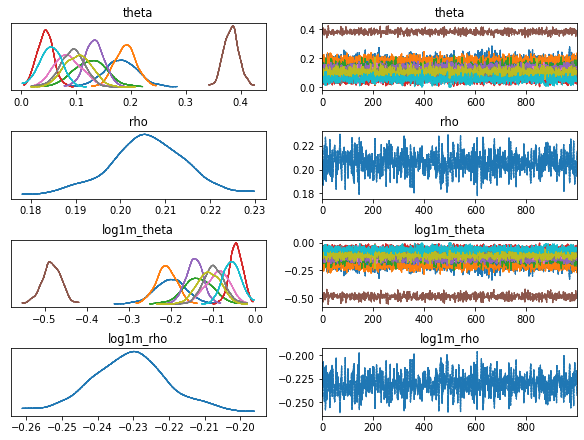

In [8]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [9]:
fit = fit.to_frame()
print("Inference on fitted model:")
fit.describe().T

Inference on fitted model:


,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,16000.0,-6244.083799,2.600639e+00,-6255.381160,-6245.592456,-6243.674758,-6242.175793,-6239.241258
accept_stat__,16000.0,0.940213,6.522104e-02,0.538875,0.915272,0.960406,0.986669,1.000000
stepsize__,16000.0,0.361898,8.265869e-14,0.361898,0.361898,0.361898,0.361898,0.361898
treedepth__,16000.0,3.458000,5.042340e-01,2.000000,3.000000,3.000000,4.000000,4.000000
n_leapfrog__,16000.0,12.108000,3.964507e+00,3.000000,7.000000,15.000000,15.000000,31.000000
divergent__,16000.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,16000.0,6249.594005,3.572676e+00,6240.867771,6247.054267,6249.271710,6251.676799,6264.177631
theta.1,16000.0,0.181797,3.058368e-02,0.089707,0.162426,0.181668,0.202333,0.284292
theta.2,16000.0,0.190226,1.966616e-02,0.128776,0.177035,0.190416,0.203350,0.246257


In [10]:
print('Ground truth:')
print(true_transmission_rate)
print(base_rate)

Ground truth:
[0.11229016 0.21544007 0.1340044  0.03496042 0.14024028 0.38996209
 0.06151853 0.09666885 0.08617048 0.05264691]
[0.20607471]
